In [26]:
import os
import numpy as np
import torch
import cv2
import manga109api
import torchvision
from torchvision import transforms
from src.dataset import Resizer, Normalizer
from src.model import EfficientDet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.filters import threshold_otsu
import pytesseract
from PIL import Image, ImageFilter
pytesseract.pytesseract.tesseract_cmd = "F://Tesseract-OCR//tesseract.exe"

In [2]:
PATH = "mangadet.pth"

In [3]:
model = EfficientDet(num_classes = 2).cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientDet(
  (conv3): Conv2d(40, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(80, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(192, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (2): BatchNorm2d(64, eps=4e-05, momentum=0.9997, affine=True, track_running_stats=True)
          (3): ReLU()
        )
      )
      (conv5_up): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
 

In [4]:
image_base_path = "F:\\Datasets\\Manga109\\images\\"
manga109_root_dir = "F:\\Datasets\\Manga109"
p = manga109api.Parser(root_dir=manga109_root_dir)

In [5]:
book = "ARMS"
page_index = 19
image_full_path = image_base_path + book + '\\'
annotation = p.get_annotation(book=book)

In [6]:
img = cv2.imread(p.img_path(book=book, index=page_index))
width, height, _ = img.shape
h_scale, w_scale = width/512, height/512
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
img = img.astype(np.float32) / 255.
img = torch.from_numpy(img).unsqueeze(0)
img = img.permute(0, 3, 1, 2).double().cuda()

In [7]:
with torch.no_grad():
    out = model(img)

In [9]:
ocr_img = Image.open(p.img_path(book=book, index=page_index))
ocr_texts = []
for box in out[2]:
    xmin = int(box[0] * w_scale)
    ymin = int(box[1] * h_scale)
    xmax = int(box[2] * w_scale)
    ymax = int(box[3] * h_scale)
    crop_img = ocr_img.crop((xmin, ymin, xmax, ymax))
    ocr_text = pytesseract.image_to_string(crop_img, lang='jpn+jpn_vert')
    ocr_texts.append(ocr_text)
    break

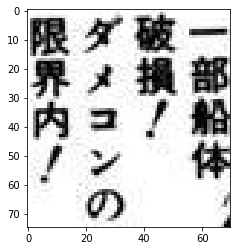

In [19]:
plt.imshow(crop_img)

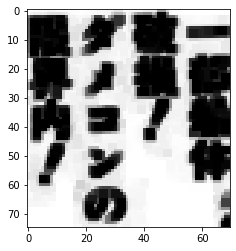

In [35]:
dilated_crop_img = crop_img.filter(ImageFilter.MinFilter(3))
plt.imshow(dilated_crop_img)

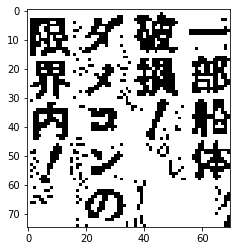

In [36]:
np_crop_img = np.array(crop_img)
np_crop_img = cv2.cvtColor(np_crop_img, cv2.COLOR_BGR2GRAY)
adp_crop_img = cv2.adaptiveThreshold(np_crop_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.imshow(adp_crop_img, cmap='gray')

In [21]:
ocr_texts

['① 送 ま\n\nダメ コン の\n限界 内 !\n\x0c',
 'そん な も ん\nこっ ち だ っ て\n見 た か\n\nョ\n\x0c',
 'が ⑨A。\nコ ー ョ ==ne\n詳細 な 資料 を\nS\n\x0c',
 'ホッ ギン グ\n\x0c',
 '⑧ な\n死ぬ と こ\nな ん て\n見 せ た く\nね え か ら\nt\n\x0c',
 'ョ ー\nな ん と か\nな らん の\n\nお れ が\n死ぬ と こ\nな ん て\n見 せ た く\nで a る\nら\n\x0c',
 '\x0c',
 'スト レス が\n増大 っ\n\x0c',
 '船体 を\n\nまかせ みろ\n\x0c',
 'リ ト ー パ\nな ん と か\nな らち ん の か\n\x0c',
 '超重 子 弾\nES\n\x0c',
 'bi に b\n\x0c',
 ' \n\x0c',
 '\x0c',
 ' \n\x0c',
 '\x0c',
 '連続 波 が\n来る ぞ グ\n\x0c',
 ' \n\n*knax\nョ ー ョ ==me\n詳細 な 資料 を\n口 R っ K\n\x0c',
 ' \n\x0c',
 ' \n\x0c',
 'ト = ト\nテキ スト\nレー ザー で\n\x0c',
 '\x0c',
 ' \n\x0c',
 '\x0c']

In [14]:
print(pytesseract.get_languages(config=''))

['eng', 'jpn', 'jpn_vert', 'osd']


In [18]:
ocr_text = pytesseract.image_to_string(crop_img, lang='jpn+jpn_vert')

In [19]:
ocr_text

'\x0c'